# Project name: [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

# Version

In [150]:
__ver__ = "0.5"

# Objective

Try new features or Get better than 0.937 score on [Public Leaderboard](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/leaderboard)

# Setup

In [151]:
import numpy as np
import pandas as pd
import catboost
import sklearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statsmodels as sm
from pmdarima import arima
%matplotlib inline 

import itertools
import warnings
import sys

warnings.filterwarnings('ignore')

def downcaster(df):
    for col in df:
        if issubclass(df[col].dtype.type, np.floating):
            df.loc[:, col] = pd.to_numeric(df.loc[:, col], downcast='float')
        if issubclass(df[col].dtype.type, np.integer):
            df.loc[:, col]   = pd.to_numeric(df.loc[:, col], downcast='integer')
    return df

# Data load

In [152]:
# path
cat_path = "./raw_data/item_categories.csv"
items_path = "./raw_data/items.csv"
shop_path = "./raw_data/shops.csv"
sales_path = "./raw_data/sales_train.csv.gz"
test_path = "./raw_data/test.csv.gz"

In [153]:
# load
cat = pd.read_csv(cat_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shop_path)
sales_params = dict(parse_dates=[0], infer_datetime_format = True, dayfirst=True)
sales = pd.read_csv(sales_path, **sales_params)
prices = pd.read_csv(sales_path, **sales_params)
# load and save ID in index
test = pd.read_csv(test_path).set_index('ID')

# Data preprocessing

 ## Categories

In [154]:
cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [155]:
# item_category_name can be split into category_group and sub_category
cat_split = cat.item_category_name.str.split(" - ")
cat["category_group"] = cat_split.apply(lambda x:  x[0].strip())
cat["sub_category"] = cat_split.apply(lambda x:  x[1].strip() if len(x) == 2 else x[0].strip())

In [156]:
# Drop, encode and downcast
cat = cat.drop("item_category_name", axis=1)
cat.category_group = preprocessing.LabelEncoder().fit_transform(cat.category_group)
cat.sub_category = preprocessing.LabelEncoder().fit_transform(cat.sub_category)
cat = downcaster(cat)
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
item_category_id    84 non-null int8
category_group      84 non-null int8
sub_category        84 non-null int8
dtypes: int8(3)
memory usage: 332.0 bytes


## Shops

In [157]:
# looks like dublicated shops 
shops.iloc[[0, 57, 1, 58, 10, 11]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


#### Shops 0 and 57

In [158]:
# shop 0 ends at 1 date_block_num               
sales[sales.shop_id == 0].date_block_num.unique()

array([0, 1])

In [159]:
# shop 57 starts at 2 date_block_num
sales[sales.shop_id == 57].date_block_num.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [160]:
# no shop 0 in test set
0 in test.shop_id.unique()

False

In [161]:
# replace shop 0 with 57
sales.loc[sales.shop_id == 0, "shop_id"] = 57

#### Shops 1 and 58

In [162]:
# shop 1 ends at 1 date_block_num               
sales[sales.shop_id == 1].date_block_num.unique()

array([0, 1])

In [163]:
# shop 58 starts at 2 date_block_num
sales[sales.shop_id == 58].date_block_num.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [164]:
# no shop 1 in test set
1 in test.shop_id.unique()

False

In [165]:
# replase shop 0 with 58
sales.loc[sales.shop_id == 1, "shop_id"] = 58

#### Shops 10 and 11

In [166]:
# shop 11 exists only at 25 date_block_num
sales[sales.shop_id == 11].date_block_num.unique()

array([25])

In [167]:
# no 25 date_block_num for shop 10
sales[sales.shop_id == 10].date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33])

In [168]:
# no shop 11 in test set
11 in test.shop_id.unique()

False

In [169]:
# replase shop 11 with 10
sales.loc[sales.shop_id == 11, "shop_id"] = 10

In [170]:
# drop bad shops
shops.drop([0, 1, 11], inplace=True)

#### Shops featues

In [171]:
# First part of shop_name is city
shops.shop_name.str.split().apply(lambda x: x[0]).unique()

array(['Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Выездная',
       'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга', 'Коломна',
       'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [172]:
shops['city'] = shops.shop_name.str.split().apply(lambda x: x[0].strip())

In [173]:
# Drop, encode and downcast
shops.drop("shop_name", axis=1, inplace=True)
shops.city = preprocessing.LabelEncoder().fit_transform(shops.city)
shops = downcaster(shops)
shops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 2 to 59
Data columns (total 2 columns):
shop_id    57 non-null int8
city       57 non-null int8
dtypes: int8(2)
memory usage: 570.0 bytes


## Items

In [174]:
# Drop, encode and downcast
items.drop("item_name", axis=1, inplace=True)
items = downcaster(items)
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 2 columns):
item_id             22170 non-null int16
item_category_id    22170 non-null int8
dtypes: int16(1), int8(1)
memory usage: 65.0 KB


## Make sales like Test

We use cliped item_cnt - no need to remove outliers.

In [175]:
# Aggregate
state_columns = ["date_block_num", "shop_id", "item_id"]
sales.drop("item_price", axis=1, inplace=True)
sales = sales.groupby(state_columns, as_index=False).sum()

In [176]:
# Rename target
new_columns = sales.columns.tolist()
new_columns[-1] = "y"
sales.columns = new_columns

In [177]:
# Test set consists of 5100 items for 42 shops
(
    len(test.item_id.unique()), 
    len(test.shop_id.unique()), 
    len(test.item_id.unique()) * (len(test.shop_id.unique())) == len(test)
)

(5100, 42, True)

In [178]:
# Sale set consists of 21807 items for 60 shops
len(sales.item_id.unique()), len(sales.shop_id.unique())

(21807, 57)

In [179]:
# There are new items in test set
len(set(test.item_id.unique()) - set(sales.item_id.unique()))

363

In [180]:
# Try drop some shops and items from sales set and add new items to make both sets similar
test_combinations = itertools.product(
    sales.date_block_num.unique(),
    test.shop_id.unique(),
    test.item_id.unique()
)
data = pd.DataFrame(
    list(test_combinations),
    columns=state_columns
)
data = data.merge(sales, on=state_columns, how="left")
data.y = data.y.fillna(0)

In [181]:
# downcast and clip to [0, 20]
data.loc[:, "y"] = data.y.clip(0, 20)
data = downcaster(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7282800 entries, 0 to 7282799
Data columns (total 4 columns):
date_block_num    int8
shop_id           int8
item_id           int16
y                 float32
dtypes: float32(1), int16(1), int8(2)
memory usage: 111.1 MB


## Stack Sales and Test

In [182]:
# add date_block_num to test
test_date_block = data.date_block_num.max() + 1
test["date_block_num"] = test_date_block
test = downcaster(test)

In [183]:
# stack train and test data
data = pd.concat([data, test], axis=0, sort=False)

## Merge all data

In [184]:
data = data.merge(shops, how="left", on="shop_id")
data = data.merge(items, how="left", on="item_id")
data = data.merge(cat, how="left", on="item_category_id")

# Feature engineering

## Seasonality

In [185]:
montly_agg = data.groupby("date_block_num")["y"].sum().iloc[:-1]

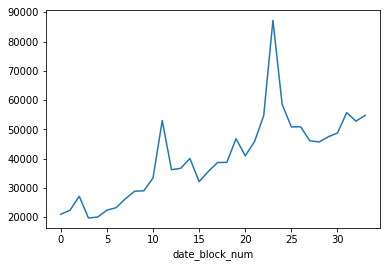

In [186]:
# Seasonality
montly_agg.plot()

In [187]:
# Add month feature
data["month"] = data.date_block_num % 12

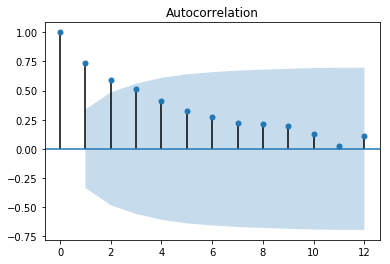

In [188]:
_ = sm.graphics.tsaplots.plot_acf(montly_agg, lags=12)

In [189]:
def make_lags(df, lag_col_name, lags):
    for i in sorted(lags):
        lagger = df[state_columns + [lag_col_name]]
        lagger.loc[:, "date_block_num"] += i
        lagger.columns = lagger.columns[:-1].tolist() + [f"{lag_col_name}_{i}"]
        df = df.merge(lagger, on=state_columns, how='left')
    return df

In [190]:
# Add some first lags and year ago
data = make_lags(data, "y", [1, 2, 3, 4, 13])

In [191]:
# Weak sign of unit root
sm.tsa.stattools.adfuller(montly_agg)

(-2.132157497160812,
 0.23178200425279727,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 491.5327212008761)

In [192]:
# Add first diff an year diff
data["diff_y1_y2"] = data["y_1"] - data["y_2"]
data["diff_y1_y13"] = data["y_1"] - data["y_13"]
data.drop("y_13", axis=1, inplace=True)

## Leaks

### We are asked about sellable items

In [193]:
# was this item sold at given date?
tmp = data.groupby(["item_id", "date_block_num"], as_index=False).agg({"y": "max"})
tmp["item_sold"] = tmp.y > 0
tmp.drop("y", axis=1, inplace=True)

In [194]:
# let's guess we make prediction for sellable items
tmp.loc[tmp.date_block_num == tmp.date_block_num.max(), "item_sold"] = True

In [195]:
# add feature
data = data.merge(tmp, how='left', on=["item_id", "date_block_num"])

### Let's mark new items for every date_block_num

In [196]:
# get new items for every date_block_num
new_matrix = []
old_items = set()
for num in sorted(sales.date_block_num.unique()):
    date_items = set(sales[sales.date_block_num == num].item_id.unique())
    if not num:
        old_items = date_items
        continue
    new_items = date_items - old_items
    new_matrix.extend(
        itertools.product(
            [num],
            new_items
        )
    )
    old_items |= date_items

In [197]:
# guess new items for test
new_items = set(test.item_id.unique()) - old_items
new_matrix.extend(
    itertools.product(
        [test_date_block],
        new_items
    )
)

In [198]:
# make feature
tmp = pd.DataFrame(new_matrix, columns=["date_block_num", "item_id"])
tmp["new_item"] = True

In [199]:
data = data.merge(tmp, how='left', on=["item_id", "date_block_num"])
data["new_item"] = data["new_item"].fillna(False)

## Items clusters

In [200]:
# Use first 12 month for items clusters - this data will be droped, so no risk leaks
tmp_gr = data[data.date_block_num < 12].groupby(["item_id", "date_block_num"]).y.mean().unstack()

In [201]:
n_cl=21

clst = KMeans(n_clusters=n_cl)
tmp = pd.DataFrame(clst.fit_predict(tmp_gr), index=tmp_gr.index, columns=[f"item_cluster_{n_cl}"], dtype="int8")
data = data.merge(tmp, how="left", left_on="item_id", right_index=True)

## Add some proxi sales mean encoded features

### Mean for every item and date

In [202]:
tmp = data.groupby(["item_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["item_date_y"]
data = data.merge(tmp, on=["item_id", "date_block_num"], how='left')

In [203]:
# Add some laggs and drop column
data = make_lags(data, "item_date_y", [1, 2, 3])
data.drop("item_date_y", axis=1, inplace=True)

### Mean for shop and date

In [204]:
tmp = data.groupby(["shop_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["shop_date_y"]
data = data.merge(tmp, on=["shop_id", "date_block_num"], how='left')

In [205]:
# Add some laggs and drop column
data = make_lags(data, "shop_date_y", [1, 2, 12])
data.drop("shop_date_y", axis=1, inplace=True)

### Mean for shop, category and date

In [206]:
tmp = data.groupby(["shop_id", "item_category_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["shop_cat_date_y"]
data = data.merge(tmp, on=["shop_id", "item_category_id", "date_block_num"], how='left')

In [207]:
# Add some laggs and drop column
data = make_lags(data, "shop_cat_date_y", [1, 2, 3])
data.drop("shop_cat_date_y", axis=1, inplace=True)

### Mean for category and date

In [208]:
tmp = data.groupby(["item_category_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["cat_date_y"]
data = data.merge(tmp, on=["item_category_id", "date_block_num"], how='left')

In [209]:
# Add some laggs and drop column
data = make_lags(data, "cat_date_y", [1, 2, 3])
data.drop("cat_date_y", axis=1, inplace=True)

### Cummean shop and item

In [210]:
tmp = data.groupby(["shop_id", "item_id"])[["y"]].cumsum()
tmp.columns = ["cummean_shop_item_y"]
tmp["date_block_num"] = data["date_block_num"] + 1
tmp["cummean_shop_item_y"] = tmp["cummean_shop_item_y"] / tmp["date_block_num"]
tmp["shop_id"] = data["shop_id"]
tmp["item_id"] = data["item_id"]
data = data.merge(tmp, on=["shop_id", "item_id", "date_block_num"], how='left')

### Cummin shop and item

In [211]:
# items not sold before in shop
tmp = data.groupby(["shop_id", "item_id"])[["y"]].cummax()
tmp.columns = ["not_sold_before"]
tmp["date_block_num"] = data["date_block_num"] + 1
tmp["shop_id"] = data["shop_id"]
tmp["item_id"] = data["item_id"]
data = data.merge(tmp, on=["shop_id", "item_id", "date_block_num"], how='left')
data["not_sold_before"] = data["not_sold_before"] == 0

## Prices

In [212]:
# I am going to use log prices - so should remove negative price
prices[prices.item_price <=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [213]:
# drop negative price and unused columns
prices.drop(484683, inplace=True)
prices.drop(["date", "item_cnt_day"], axis=1, inplace=True)

In [214]:
# take log
prices.item_price = prices.item_price.apply(np.log)

In [215]:
# let's aggregate with more robust median and downcast
prices = downcaster(prices.groupby(state_columns, as_index=False).median())

In [216]:
# add to data
data = data.merge(prices, on=state_columns, how='left')

### Price discount in shop

In [217]:
# add median of all shops
tmp = data.groupby(["item_id", "date_block_num"]).item_price.median()
tmp.name = "avr_price"
data = data.merge(tmp.to_frame(), left_on=["item_id", "date_block_num"], right_index=True, how='left')

In [218]:
# add discont
data["price_discount"] = data.item_price - data.avr_price
data["price_discount"] = data["price_discount"].fillna(0)

In [219]:
# lag it
data = make_lags(data, "price_discount", [1])
data.drop("price_discount", axis=1, inplace=True)

### Price growth

In [220]:
price_lags = [1, 6]

In [221]:
data = make_lags(data, "avr_price", price_lags)
data.drop(["item_price", "avr_price"], axis=1, inplace=True)

In [222]:
for i in price_lags:
    if i == 1:
        continue
    data[f"price_growth_1_{i}"] = data["avr_price_1"] - data[f"avr_price_{i}"]
    data[f"price_growth_1_{i}"] = data[f"price_growth_1_{i}"].fillna(0)
    data.drop(f"avr_price_{i}", axis=1, inplace=True)
data.drop("avr_price_1", axis=1, inplace=True)

## Save processed data

In [223]:
processed_path = f"./processed_data/data_{__ver__}.pickle"

In [224]:
data.to_pickle(processed_path)